In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

# Synthetic data

In [4]:
import os, sys

In [5]:
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

## Basic components

### Event times

Start with an array of timepoints with 1 second resolution

In [6]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

---

### Stays

* specify the beginning and ends of stays, along with location (_ie_ $t_0, t_1, x$, resp.)

In [7]:
from synthetic_data.trajectory import get_stay

stays = [
        get_stay(  0.00,  8.00,-1.00), #home
        get_stay(  8.50, 12.00, 1.10), #work, morning
        get_stay( 12.25, 13.25, 1.60), #lunch
        get_stay( 13.50, 18.00, 1.10), #work, afternoon
        get_stay( 18.50, 20.30,-0.50), #gym
        get_stay( 20.50, 21.50,-2.00), #shopping
        get_stay( 22.00, 24.00, 0.00)  # overnight
    ]

---

### from stays, get travels, segments, and trajectory
* travels are generated automatically and connect the endpoints adjacent stays
* segments are stays and travels
    * these are generated for later use, namely in the evaluation.

In [8]:
time_thresh = 1/6 # in hours
dist_thresh=0.25 # in kilommeters

---

### Trajectory
* the trajectory is the arrays
    * time points
    * raw event locations
    * noisy event locations (raw event locations plus noise)
* the trajectory can be specified by the stays (and even the segments), or it can be randomly generated.

In [9]:
event_frac = 0.1 #rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(0.05, 0.3, 1)[0]

configs = {
    'time_thresh':time_thresh,
    'dist_thresh':dist_thresh,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.0,
    'noise_max':0.0
}

In [10]:
from synthetic_data.trajectory import get_stay_segs
from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_adjusted_stays

In [11]:
t_segs, x_segs = get_stay_segs(stays)
t_arr, r_arr, x_arr, segments = get_trajectory(stays, time, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

In [13]:
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes, add_plot_trajectory

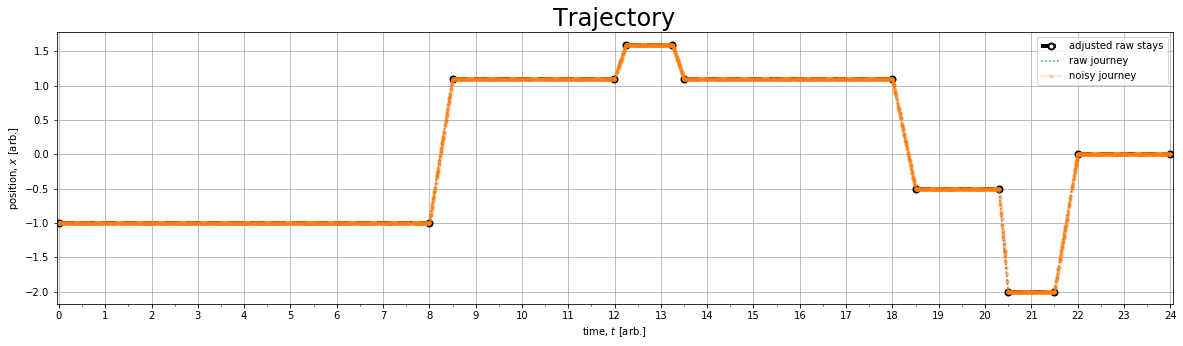

In [14]:
plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh);

---

### Noise

Since the mobile signalling data is inherently noisy, it is useful for the trajectory to have some gaussian noise included.

Adding noise to the trajectory is configurable, with minima and maxima from the true location specified. The levels of noise are varied with each segment: one stay will have different noise profile than another, and the same goes for travels. This is meant to mimic the spatial dependence of the noise. 

In [66]:
event_frac = 0.02 #rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.0 #rand_range(0.05, 0.3, 1)[0]

configs = {
    'time_thresh':time_thresh,
    'dist_thresh':dist_thresh,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.10,
    'noise_max':0.15
}

In [67]:
t_segs, x_segs = get_stay_segs(stays)
t_arr, r_arr, x_arr, segments = get_trajectory(stays, time, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

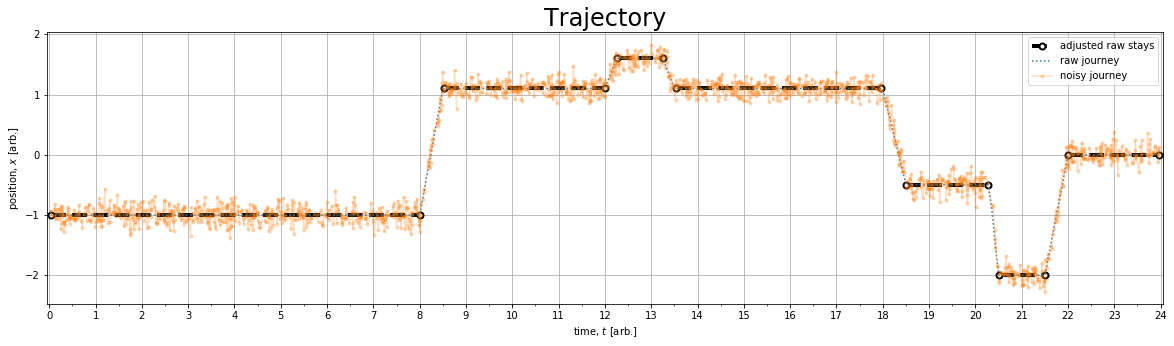

In [68]:
ax = plot_trajectory(t_arr, r_arr, x_arr,t_segs, x_segs, dist_thresh);

**Notes**
Real signalling data has more than just gaussian noise:
* Depending on the available sources, locations can be those only of the serving antenna's position. 
* Sometimes the events can be received into the data late. 
* There can be network dynamics which see a device connect to an antenna that is very far away from the actual device position. 
* Some of the noise can be repeated locations, where the device is placed at the antenna. 
* When there is a triangulation system in place, some locations will be incorrectly placed a roughly fixed distance from the antenna, tracing out arcs of device motion eventhough the device may be stationary. 

To get a real feel, the noise must be measured and the probability distributions identified and then used, and that would require precise location data to compare with. 

---

### Event density

The number of events in a signalling data will not always be given continuously. Therefore, functionality is included to vary the event density. 

This is specified by using a fraction from the total number of events within the time range given. 
For example, 86k unique events are possible within 24hrs; getting 0.1 of this results in still 9k events, which is very high.

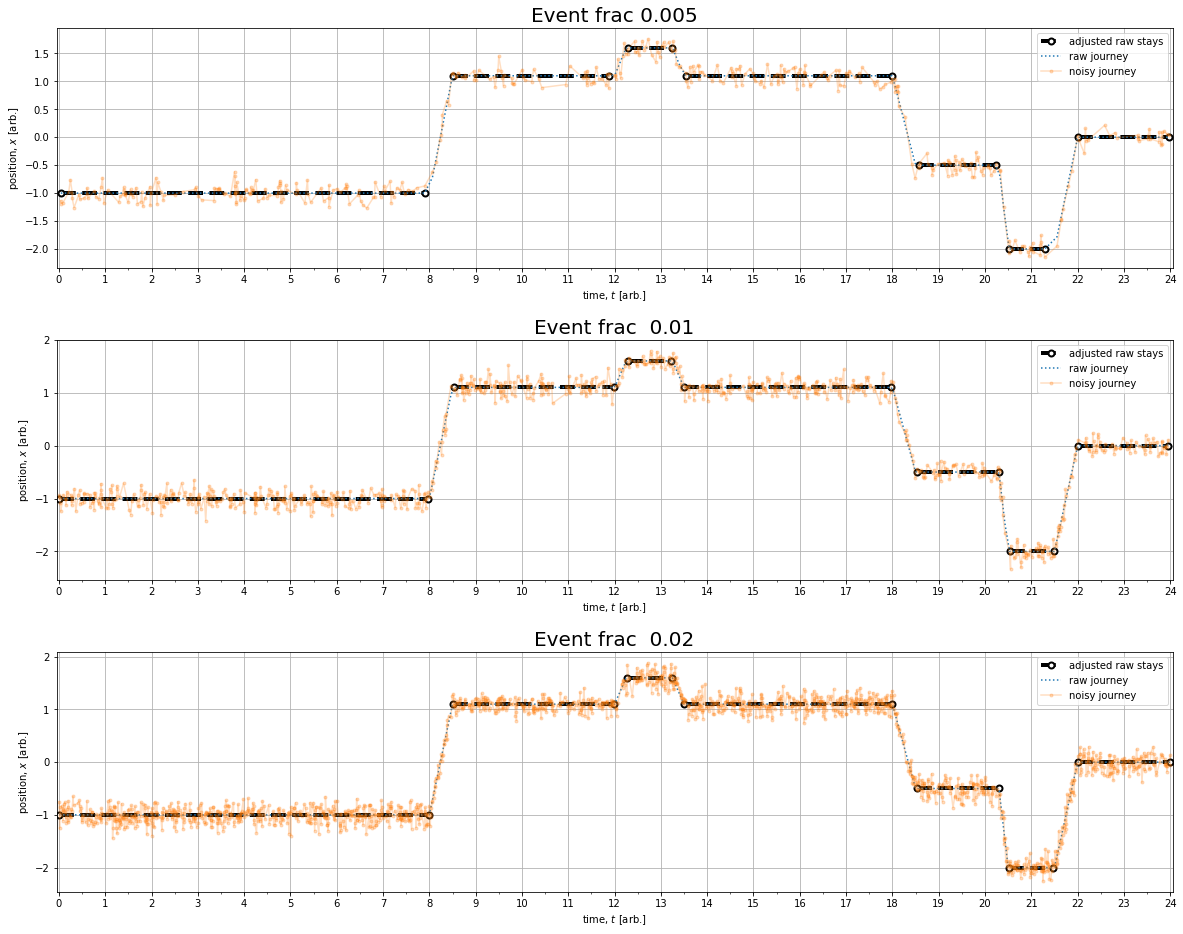

In [20]:
fig, axs = plt.subplots(3,1,figsize=[20,15])
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)
event_frac = [0.005, 0.01, 0.02]
for n, ax in enumerate(axs.flatten()):
    configs['event_frac'] = event_frac[n]
    t_arr, r_arr, x_arr, segments = get_trajectory(stays, time, configs)
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))
    add_plot_trajectory(t_arr, r_arr, x_arr,t_segs, x_segs, dist_thresh, ax)
    ax.set_title(f'Event frac {event_frac[n]:5.3}', fontsize=20)

---

### Duplicate events

Here, time points can be repeated, as signalling can have apparent simultaneous events. 

The configs can set the fraction of duplicates. This does not affect the the event fraction, which will always give the same number of events.

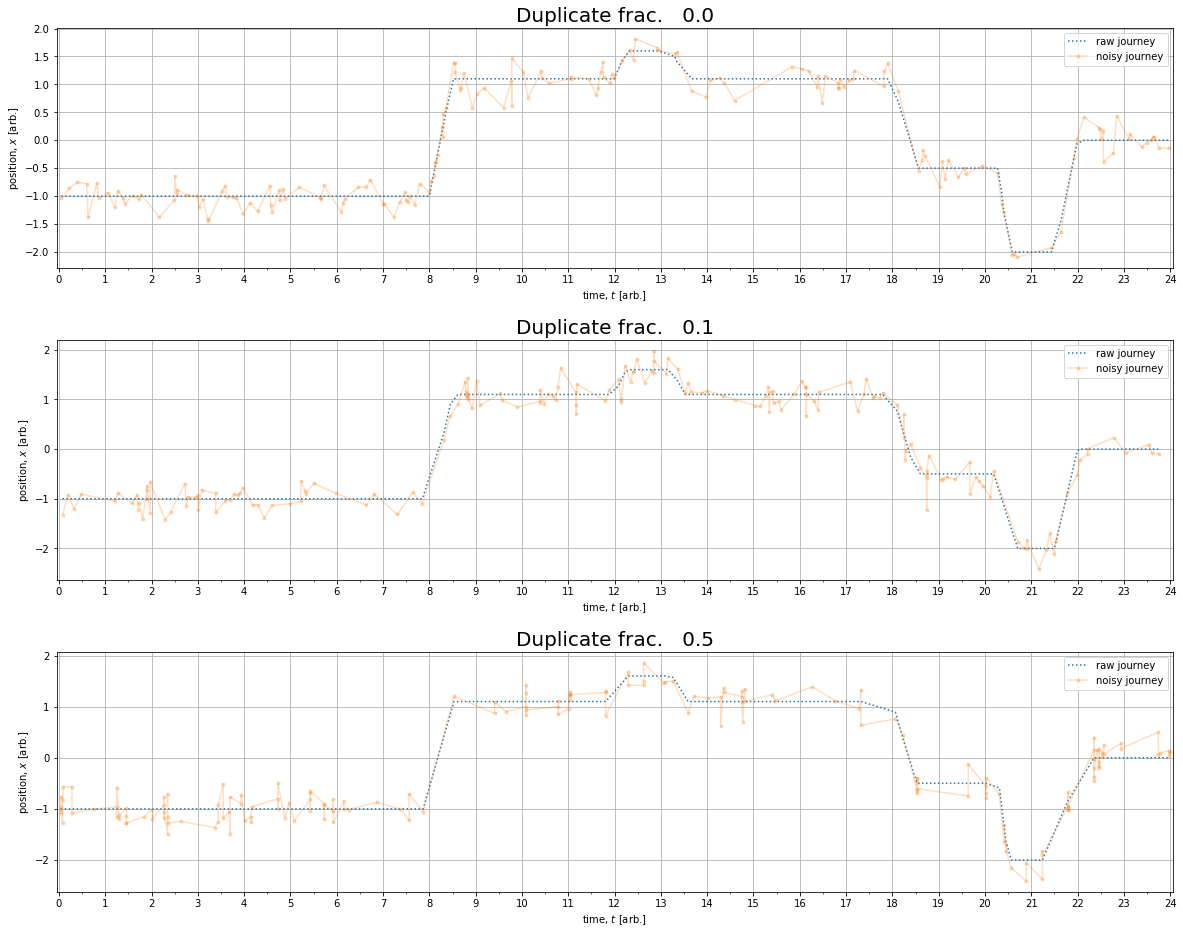

In [22]:
fig, axs = plt.subplots(3,1,figsize=[20,15])
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)
duplicate_frac = [0.0, 0.1, 0.5]
configs['event_frac'] = 0.002
configs['noise_min'] = 0.200
configs['noise_max'] = 0.201
for n, ax in enumerate(axs.flatten()):
    configs['duplicate_frac'] = duplicate_frac[n]
    t_arr, r_arr, x_arr, segments = get_trajectory(stays, time, configs)
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))
    add_plot_trajectory(t_arr, r_arr, x_arr, None, None, dist_thresh, ax)
    ax.set_title(f'Duplicate frac. {duplicate_frac[n]:5.3}', fontsize=20)

**Note** since the number of events is the same, increasing the duplicates fraction results in piling the events at certain (though random) timepoints, giving more gaps in between temporal clusters; this is often a feature of signalling data where multiple packets of information are sent roughly the same time.

---

### Random trajectories

In order to test a large amount of data, functionality is given to produce a set of random trajectories. 

The random trajectories have a few random features:
* mostly, the stays' number, location, and durations are random
    * the number of stays follows a log-normal distribution, which peaks at 3 stays. 
* the start and stop locations of the trajectory are random
    * this should also follow a distribution other than uniform.
* the trajectory duration is random
    * this should also follow a distribution other than uniform.
    
These have a few criteria which are met:
* the distance between adjacent stays should be mostly outside of a buffer
    * this is useful to test the algorithm's spatial resolution
* the implicit speed during a travel is limited
    * the speed must not go below 3.6 km/hr, meaning the slopes can't be too shallow. 
        * a speed slower than this is physically unreasonable
        * this is slightly more than twice the speed limit implied by the (usual) time- and distance-thresholds
    * a similar limit should exist for faster than human travel speeds, but this is currently not an issue for the stay classification.

In [23]:
from synthetic_data.trajectory_class import get_rand_traj

In [51]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = rand_range(0.05, 0.3, 1)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

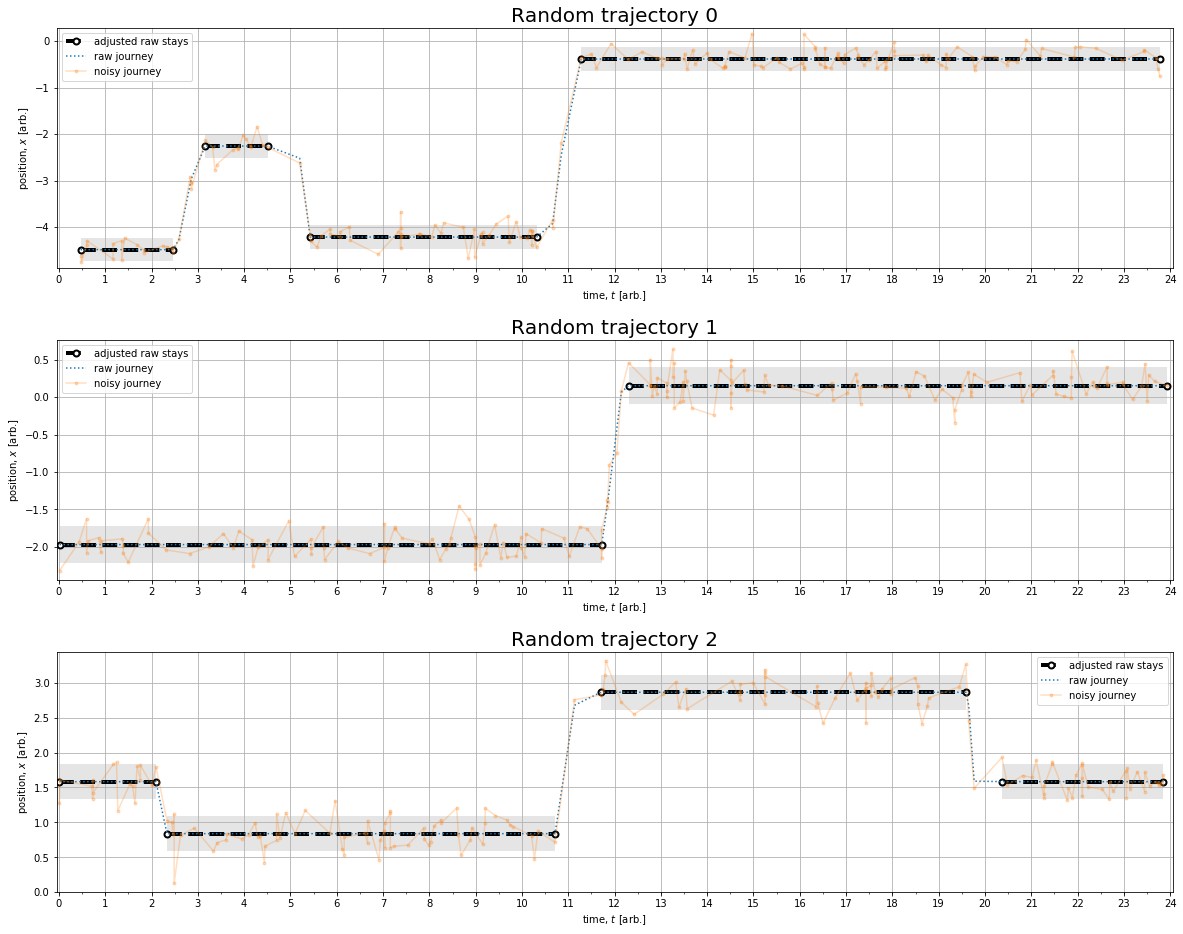

In [54]:
d_thresh_plot_buff = 0.5

fig, axs = plt.subplots(3,1,figsize=[20,15])
fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.3)
duplicate_frac = [0.0, 0.1, 0.6]
configs['event_frac'] = 0.002
configs['noise_min'] = 0.18
configs['noise_max'] = 0.20
for n, ax in enumerate(axs.flatten()):
    time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
    ylim = [noise_arr.min()-d_thresh_plot_buff*dist_thresh, noise_arr.max()+d_thresh_plot_buff*dist_thresh]

    add_plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh, ax)
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
    ax.set_ylim(ylim)
    ax.set_title(f'Random trajectory{n:2d}', fontsize=20)
    

**Note** the grey shaded boxes above show a buffer around the raw stay locations; this buffer can be specified and is meant to coincide with the distance threshold used in the algorithm.

---

## Appendix: Plotting tools

As seen in the plots above, there are a few standard plots which are helpful
1. plotting a trajectory
    * the raw and noisy positions
2. plotting the stays
3. plotting the buffers around stays
4. plotting the box-plots of the locations within a stay
    * see below
    * these are configured to overlap with the stays for better visualization.

In [55]:
from synthetic_data.trajectory import get_stay_indices

In [63]:
stay_indices = []
for i in get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr):
    l = list(range(i[0],i[-1]+1))
    stay_indices.append(l)

In [64]:
from synthetic_data.plotting import add_plot_cluster_boxplots

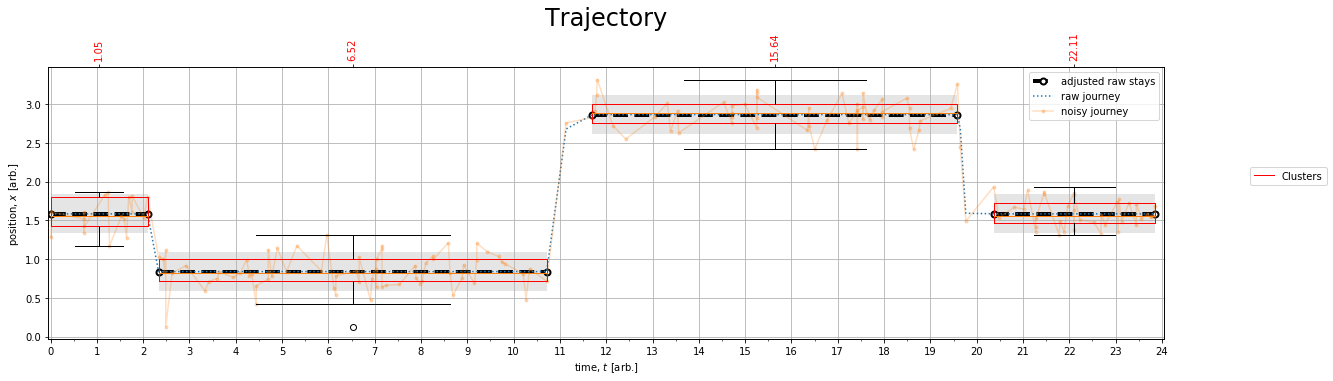

In [62]:
fig = plt.figure(figsize=[20,5])
ax = fig.gca()
add_plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh, ax)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, stay_indices, dist_thresh, ax)

**Note** the box plots line up nicely with the raw stay location lines as well as the buffers.